<a href="https://colab.research.google.com/github/t-nakatani/signate_stu22/blob/exp/signate_stu_v37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v36との比較.
被りラベル3つ全部同一の場合suede-labeling
CV=0.806, LB=0.725

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/MyDrive/Colab Notebooks/signate/"

#学習用データと評価用データの読み込み
train = pd.read_csv(os.path.join(ROOT, "train.csv")).drop_duplicates(subset='description')
test = pd.read_csv(os.path.join(ROOT, "test.csv"))

jobdic = dict(zip([1, 2, 3, 4], ['DataScientist', 'ML Engineer', 'Software Engineer', 'Consultant']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        # #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が1文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 1]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_short_tokenized)
        
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

train['description'] = cleaning(train['description'])
test['description'] = cleaning(test['description'])

In [3]:
!pip install -q transformers==3

In [4]:
df_v10 = pd.read_csv(os.path.join(ROOT, 'v10_ensemble.csv'), header=None)
df_v31 = pd.read_csv(os.path.join(ROOT, 'v31_ensemble.csv'), header=None)
df_v34 = pd.read_csv(os.path.join(ROOT, 'v34_ensemble.csv'), header=None)

df_concat = pd.DataFrame([df_v10[0], df_v10[1], df_v31[1], df_v34[1]]).T
dup_ids = []
remain_ids = []
for idx, v1, v2, v3 in df_concat.to_numpy():
  if v1 == v2 == v3:
    dup_ids.append(idx-1516)
  else:
    remain_ids.append(idx-1516)

test_remained = test.iloc[remain_ids]
test_suede_labeled = test
test_suede_labeled['jobflag'] = df_v10[1]
test_suede_labeled = test_suede_labeled.iloc[dup_ids]

In [5]:
test_suede_labeled

,id,description,jobflag
0,1516,Building decision making models and proposing ...,1
1,1517,Educate homeowners on the benefits of solar en...,4
2,1518,Design develop document and implement web appl...,3
3,1519,Apply advanced technical expertise and skills ...,4
4,1520,Project manage and deliver against our roadmap...,3
...,...,...,...
1512,3028,Manages the development of interface requireme...,3
1513,3029,Lead the implementation of new statistical mod...,1
1514,3030,Configure Zuora to fulfill use casesIdentify a...,3
1515,3031,Gather translate and document stakeholder requ...,4


In [6]:
test_remained

,id,description
6,1522,Create validate and stress test the algorithms...
8,1524,Manage individual project priorities deadlines...
9,1525,Collaborate with other developers as member of...
50,1566,Research design and build high volume low late...
64,1580,Training forecast models assessing accuracies ...
...,...,...
1484,3000,Support Product owner and Product Manager Supp...
1489,3005,Decompose user requirements into logical funct...
1495,3011,You will work with stakeholders across the org...
1501,3017,Coach and transfer knowledge by working side b...


In [7]:
train = pd.concat([train, test_suede_labeled])
print(len(train))
train =train.drop_duplicates(subset='description')
print(len(train))
test = test_remained
print(len(test))

2777
2696
247


In [8]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score

In [9]:
# seeds
SEED = 2022
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    current_device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(current_device))

Device: Tesla P100-PCIE-16GB


In [10]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.X)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      truncation=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    labels = self.y[index]

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(labels)
    }

1. from_pretrainedの文字列でconfig.from_pretrainedを呼び出し
2. config.from_pretrainedの結果をconfigにセット

In [11]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.config = AutoConfig.from_pretrained("roberta-base", num_labels=4)
    self.bert = AutoModelForSequenceClassification.from_pretrained("roberta-base", config=self.config)

  def forward(self, ids, mask):
    out = self.bert(ids, attention_mask=mask)
    return out[0]

In [12]:
def calculate_loss_and_f1_score(model, criterion, loader, device, epoch, max_epoch):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  all_labels = []
  all_preds = []

  with torch.no_grad():
    with tqdm(loader) as pbar:
      pbar.set_description('valid')
      for i, data in enumerate(pbar):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        labels = data['labels'].to(device)


        outputs = model(ids, mask)
        loss += criterion(outputs, labels).item()

        preds = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
        labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
        all_labels += labels.tolist()
        all_preds += preds.tolist()
        total += len(labels)
        correct += (preds == labels).sum().item()
        pbar.set_postfix(loss=loss/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

  return loss / len(loader), f1_score(all_labels, all_preds, average="macro")

In [13]:
def train_val(train_loader, val_loader, model_path):
  device = 'cuda' if cuda.is_available() else 'cpu'
  model = BERTClass(DROP_RATE, OUTPUT_SIZE).to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
  
  log_valid = []
  best_acc = 0
  all_labels = []
  all_preds = []

  # train
  for epoch in range(NUM_EPOCHS):
    print('\nepoch:', epoch+1)
    loss_train = correct = total = 0
    model.train()
    with tqdm(train_loader) as pbar:
      pbar.set_description('train')
      for i, data in enumerate(pbar):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        labels = data['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        preds = torch.argmax(outputs, dim=-1).cpu().numpy()
        labels = torch.argmax(labels, dim=-1).cpu().numpy()

        all_labels += labels.tolist()
        all_preds += preds.tolist()

        total += len(labels)
        correct += (preds == labels).sum().item()
        pbar.set_postfix(loss=loss_train/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

    loss_valid, f1_valid = calculate_loss_and_f1_score(model, criterion, val_loader, device, epoch, NUM_EPOCHS)
    log_valid.append([loss_valid, f1_valid])
    if best_acc < f1_valid:
      best_acc = f1_valid
      
      torch.save(model, os.path.join(ROOT, model_path))
      print('==== model saved ====')

  return log_valid

In [14]:
DROP_RATE = 0.1
OUTPUT_SIZE = 4
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 5e-6
N_CV = 5
VERSION = 'v37'

In [15]:
import sklearn.metrics
def train_val_predict(
        df_train,       # 学習用のデータ
        text_column,    # 対象のカラム名
        target_column,  # 目的変数のカラム名
        df_valid=None,  # 検証用データ
        df_val_test=None,       # 予測用データ
        model_file_prefix="",  # 保存時のファイル名識別子
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        from_pretrained = False
    ):
  
    # model
    model_path = "{}_{}.pth".format(model_file_prefix, VERSION)
    if from_pretrained:
      model = from_pretrained
      print('=== loading model from local ===')
    else:
      model = BERTClass(DROP_RATE, OUTPUT_SIZE)
      print('=== loading model from remote ===')
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
    device = 'cuda' if cuda.is_available() else 'cpu'

    # dataset
    df_val_test[target_column].fillna(0)

    max_len = 512
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    dataset_train = CreateDataset(df_train[text_column].values, pd.get_dummies(df_train[target_column]).values, tokenizer, max_len)
    dataset_val = CreateDataset(df_valid[text_column].values, pd.get_dummies(df_valid[target_column]).values, tokenizer, max_len)
    dataset_test = CreateDataset(df_val_test[text_column].values, pd.get_dummies(df_val_test[target_column]).values, tokenizer, max_len)

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_valid = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

    # train
    print(f'\n================  start train ({model_file_prefix}) ================')
    metric = train_val(dataloader_train, dataloader_valid, model_path)
    print(f'================  end train ({model_file_prefix}) ================\n')

    # predict
    model = torch.load(os.path.join(ROOT, model_path))
    model.eval()
    pred_y_list = []
    emb_list = []
    with torch.no_grad():
      with tqdm(dataloader_test) as pbar:
        pbar.set_description('test')
        for data in pbar:
          ids = data['ids'].to(device)
          mask = data['mask'].to(device)
          labels = data['labels'].to(device)

          output = model.forward(ids, mask)
          pred = torch.argmax(output, dim=-1).cpu().numpy()

          pred_y_list.extend(pred)
          emb_list.extend(output.cpu().numpy())
    return metric, pred_y_list, emb_list

In [16]:
import sklearn.model_selection

text_column, target_column, n_splits = ('description', 'jobflag', N_CV)

df = pd.concat([train, test], ignore_index=True, sort=False)
df_train = df[df[target_column].notnull()]
df_test = df[df[target_column].isnull()]

df_train_idx = df_train.index

# store result
df_pred = pd.DataFrame(df.index, columns=["index"]).set_index("index")
df_emb = pd.DataFrame(df.index, columns=["index"]).set_index("index")
df_emb_pred = None
metric_list = []
all_emb = []

# cross validation
kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for i, (train_idx, test_idx) in enumerate(kf.split(df_train, df_train[target_column])):
  df_train_sub = df_train.iloc[train_idx]
  df_test_sub = df_train.iloc[test_idx]

  df_val_test = pd.concat([df_test_sub, df_test], ignore_index=True, sort=False)

  model_file_prefix = "cv_{}".format(i)

  # train
  metric, pred_y_list, emb_list = train_val_predict(
      df_train=df_train_sub, 
      text_column=text_column,
      target_column=target_column, 
      df_valid=df_test_sub,
      df_val_test=df_val_test,
      model_file_prefix=model_file_prefix,
  )
  metric_list.append(metric)
  all_emb.append(emb_list)
  # break

- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== loading model from remote ===

================  start train (cv_0) ================


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s, f1=0.603, loss=0.572]


==== model saved ====

epoch: 2


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.684, loss=0.518]


==== model saved ====

epoch: 3


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.743, loss=0.483]


==== model saved ====

epoch: 4


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.75, loss=0.461]


==== model saved ====

epoch: 5


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.767, loss=0.493]


==== model saved ====

epoch: 6


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.791, loss=0.472]


==== model saved ====

epoch: 7


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.763, loss=0.546]



epoch: 8


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.779, loss=0.546]



epoch: 9


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.745, loss=0.619]



epoch: 10


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.759, loss=0.716]


================  end train (cv_0) ================



test: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== loading model from remote ===

================  start train (cv_1) ================


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 34/34 [00:09<00:00,  3.44it/s, f1=0.617, loss=0.537]


==== model saved ====

epoch: 2


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.68, loss=0.455]


==== model saved ====

epoch: 3


valid: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s, f1=0.779, loss=0.444]


==== model saved ====

epoch: 4


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.8, loss=0.434]


==== model saved ====

epoch: 5


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.816, loss=0.424]


==== model saved ====

epoch: 6


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.817, loss=0.442]


==== model saved ====

epoch: 7


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.816, loss=0.477]



epoch: 8


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.813, loss=0.505]



epoch: 9


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.802, loss=0.566]



epoch: 10


valid: 100%|██████████| 34/34 [00:09<00:00,  3.50it/s, f1=0.809, loss=0.517]


================  end train (cv_1) ================



test: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== loading model from remote ===

================  start train (cv_2) ================


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s, f1=0.6, loss=0.58]


==== model saved ====

epoch: 2


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.799, loss=0.485]


==== model saved ====

epoch: 3


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.811, loss=0.481]


==== model saved ====

epoch: 4


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.804, loss=0.486]



epoch: 5


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.8, loss=0.446]



epoch: 6


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.822, loss=0.463]


==== model saved ====

epoch: 7


valid: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s, f1=0.799, loss=0.475]



epoch: 8


valid: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s, f1=0.819, loss=0.476]



epoch: 9


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.799, loss=0.511]



epoch: 10


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.822, loss=0.532]


================  end train (cv_2) ================



test: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== loading model from remote ===

================  start train (cv_3) ================


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s, f1=0.566, loss=0.68]


==== model saved ====

epoch: 2


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.7, loss=0.451]


==== model saved ====

epoch: 3


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.772, loss=0.455]


==== model saved ====

epoch: 4


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.766, loss=0.432]



epoch: 5


valid: 100%|██████████| 34/34 [00:09<00:00,  3.55it/s, f1=0.789, loss=0.435]


==== model saved ====

epoch: 6


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.765, loss=0.435]



epoch: 7


valid: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s, f1=0.778, loss=0.489]



epoch: 8


valid: 100%|██████████| 34/34 [00:09<00:00,  3.50it/s, f1=0.795, loss=0.461]


==== model saved ====

epoch: 9


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.747, loss=0.587]



epoch: 10


valid: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s, f1=0.763, loss=0.531]


================  end train (cv_3) ================



test: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== loading model from remote ===

================  start train (cv_4) ================


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 34/34 [00:09<00:00,  3.46it/s, f1=0.608, loss=0.579]


==== model saved ====

epoch: 2


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.711, loss=0.475]


==== model saved ====

epoch: 3


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.771, loss=0.496]


==== model saved ====

epoch: 4


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.769, loss=0.494]



epoch: 5


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.81, loss=0.434]


==== model saved ====

epoch: 6


valid: 100%|██████████| 34/34 [00:09<00:00,  3.48it/s, f1=0.777, loss=0.486]



epoch: 7


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.806, loss=0.49]



epoch: 8


valid: 100%|██████████| 34/34 [00:09<00:00,  3.50it/s, f1=0.768, loss=0.552]



epoch: 9


valid: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s, f1=0.764, loss=0.573]



epoch: 10


valid: 100%|██████████| 34/34 [00:09<00:00,  3.52it/s, f1=0.777, loss=0.626]


================  end train (cv_4) ================



test: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


In [17]:
all_emb_ = np.array([np.array(emb)[-len(df_test):] for emb in all_emb])

mean_df = pd.DataFrame([[np.mean(arr_val) for arr_val in arr_vec] for arr_vec in np.moveaxis(all_emb_, 0, 2)])
preds = [np.argmax(arr)+1 for arr in mean_df.to_numpy()]
df_submit = pd.DataFrame([df_test.id.to_list(), preds]).T
df_submit.to_csv(os.path.join(ROOT, f'{VERSION}_ensemble.csv'), index=None, header=None)

In [18]:
f1_list = []
for item in metric_list:
  f1_list.append((np.max([acc for loss, acc in item])))
print(np.mean(f1_list))

0.8069639782451281


In [19]:
df_final_submit = df_v10.copy()
for id, label in zip(df_submit[0].values, df_submit[1].values):
  idx = id - 1516
  df_final_submit.iloc[idx, 1] = label
df_final_submit.to_csv(os.path.join(ROOT, f'{VERSION}_suede_ensemble.csv'), index=None, header=None)

In [20]:
df_final_submit

,0,1
0,1516,1
1,1517,4
2,1518,3
3,1519,4
4,1520,3
...,...,...
1512,3028,3
1513,3029,1
1514,3030,3
1515,3031,4


### 振り返り
得意な傾向にあるデータが学習データに増えて不得意な傾向にあるデータの予測がうまくいかなかったか？

In [42]:
og_train = pd.read_csv(os.path.join(ROOT, "train.csv")).drop_duplicates(subset='description')
df_v36 = pd.read_csv(os.path.join(ROOT, 'v36_suede_ensemble.csv'), header=None)

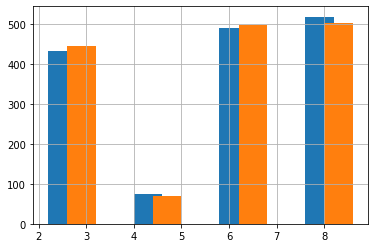

In [49]:
# ラベルの変化
(df_v31[1]*2+0.2).hist() # orange
(df_final_submit[1]*2+0.6).hist() # red

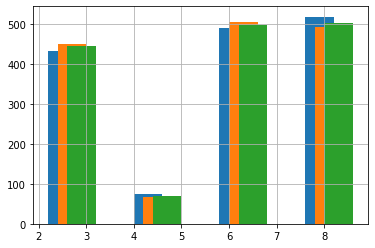

In [50]:
# (og_train.jobflag*2).hist() # blue
(df_v31[1]*2+0.2).hist() # orange
(df_v36[1]*2+0.4).hist() # green
(df_final_submit[1]*2+0.6).hist() # red